This notebook looks at pretrained AlexNet and VGGNet models from PyTorch and TensorFlow. The notebook is broken into two sections, AlexNet and VGGNet, each with a PyTorch and TensorFlow section. There will be duplicated code throughout this notebook -- I am attempting to design it so that each of the four sections (AlexNet PyTorch/TensorFlow and VGGNet PyTorch/TensorFlow) can be executed independent of other sections. My thoughts are at the bottom.

[Another helpful resource](https://www.kaggle.com/code/timothyabwao/detecting-breast-cancer-with-computer-vision)

# AlexNet

## PyTorch

For the PyTorch AlexNet I used a pretrained network to try to predict my dog (a labrador retriver).

In [70]:
import torch
from torchvision import models, transforms
from PIL import Image

In [71]:
alexnet = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

In [72]:
image_path = "ollie.jpg"

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image = Image.open(image_path)
image = transform(image)

In [73]:
alexnet.eval()

with torch.no_grad():
    image = image.unsqueeze(0)
    outputs = alexnet(image)

_, predicted = outputs.max(1)

with open("imagenet_classes.txt") as f:
    labels = [line.strip() for line in f.readlines()]

predicted_label = labels[predicted.item()]

print(f"Predicted class: {predicted_label}")

Predicted class: 208: 'Labrador retriever',


## TensorFlow

There is no pretrained AlexNet network in TensorFlow. I implemented an adapted version of the model described in [this paper](https://medium.com/swlh/alexnet-with-tensorflow-46f366559ce8). I adapted it to use eight layers as seen in the image in the "Network Structure" section of our [Applied Project Preliminary Results paper](https://docs.google.com/document/d/1DmavYVNsltkGtzsPVeR-v5JpVrZ6H0nNSg_UOQiop2k/edit). I also significantly reduced the size of the training set and the number of epochs in an effort to make it run faster -- I was not concerned with maximum accuracy, rather feasability.

In [74]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses

In [75]:
(x_train,y_train),(x_test,y_test) = datasets.mnist.load_data()
subset_size = 2000  # You can adjust this number
x_train = x_train[:subset_size]
y_train = y_train[:subset_size]
# Preprocess the data
x_train = tf.pad(x_train, [[0, 0], [2, 2], [2, 2]]) / 255
x_train = tf.expand_dims(x_train, axis=3, name=None)
x_train = tf.repeat(x_train, 3, axis=3)

validation_size = 400 
x_val = x_train[-validation_size:]
y_val = y_train[-validation_size:]
x_train = x_train[:-validation_size]
y_train = y_train[:-validation_size]

In [76]:
model = models.Sequential()
model.add(layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=x_train.shape[1:]))
model.add(layers.Conv2D(96, 11, strides=4, padding='same'))
model.add(layers.Lambda(tf.nn.local_response_normalization))
model.add(layers.Conv2D(256, 5, strides=4, padding='same'))
model.add(layers.MaxPooling2D(3, strides=2))
model.add(layers.Lambda(tf.nn.local_response_normalization))
model.add(layers.Conv2D(384, 3, strides=4, padding='same'))
model.add(layers.MaxPooling2D(2, strides=2))
model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_4 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 56, 56, 96)        34944     
                                                                 
 lambda_8 (Lambda)           (None, 56, 56, 96)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 14, 14, 256)       614656    
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 6, 6, 256)         0         
 g2D)                                                            
                                                                 
 lambda_9 (Lambda)           (None, 6, 6, 256)         0         
                                                      

In [77]:
model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [78]:
history = model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
25/25 [==============================] - 14s 548ms/step - loss: 1.4275 - accuracy: 0.5063 - val_loss: 0.5300 - val_accuracy: 0.8250
Epoch 2/10
25/25 [==============================] - 14s 548ms/step - loss: 0.4440 - accuracy: 0.8625 - val_loss: 0.2156 - val_accuracy: 0.9350
Epoch 3/10
25/25 [==============================] - 13s 539ms/step - loss: 0.2639 - accuracy: 0.9200 - val_loss: 0.3593 - val_accuracy: 0.9050
Epoch 4/10
25/25 [==============================] - 14s 543ms/step - loss: 0.2439 - accuracy: 0.9250 - val_loss: 0.3059 - val_accuracy: 0.9250
Epoch 5/10
25/25 [==============================] - 13s 541ms/step - loss: 0.1781 - accuracy: 0.9419 - val_loss: 0.7039 - val_accuracy: 0.8725
Epoch 6/10
25/25 [==============================] - 14s 542ms/step - loss: 0.2190 - accuracy: 0.9269 - val_loss: 0.2594 - val_accuracy: 0.9300
Epoch 7/10
25/25 [==============================] - 14s 544ms/step - loss: 0.1320 - accuracy: 0.9575 - val_loss: 0.5064 - val_accuracy: 0.9100

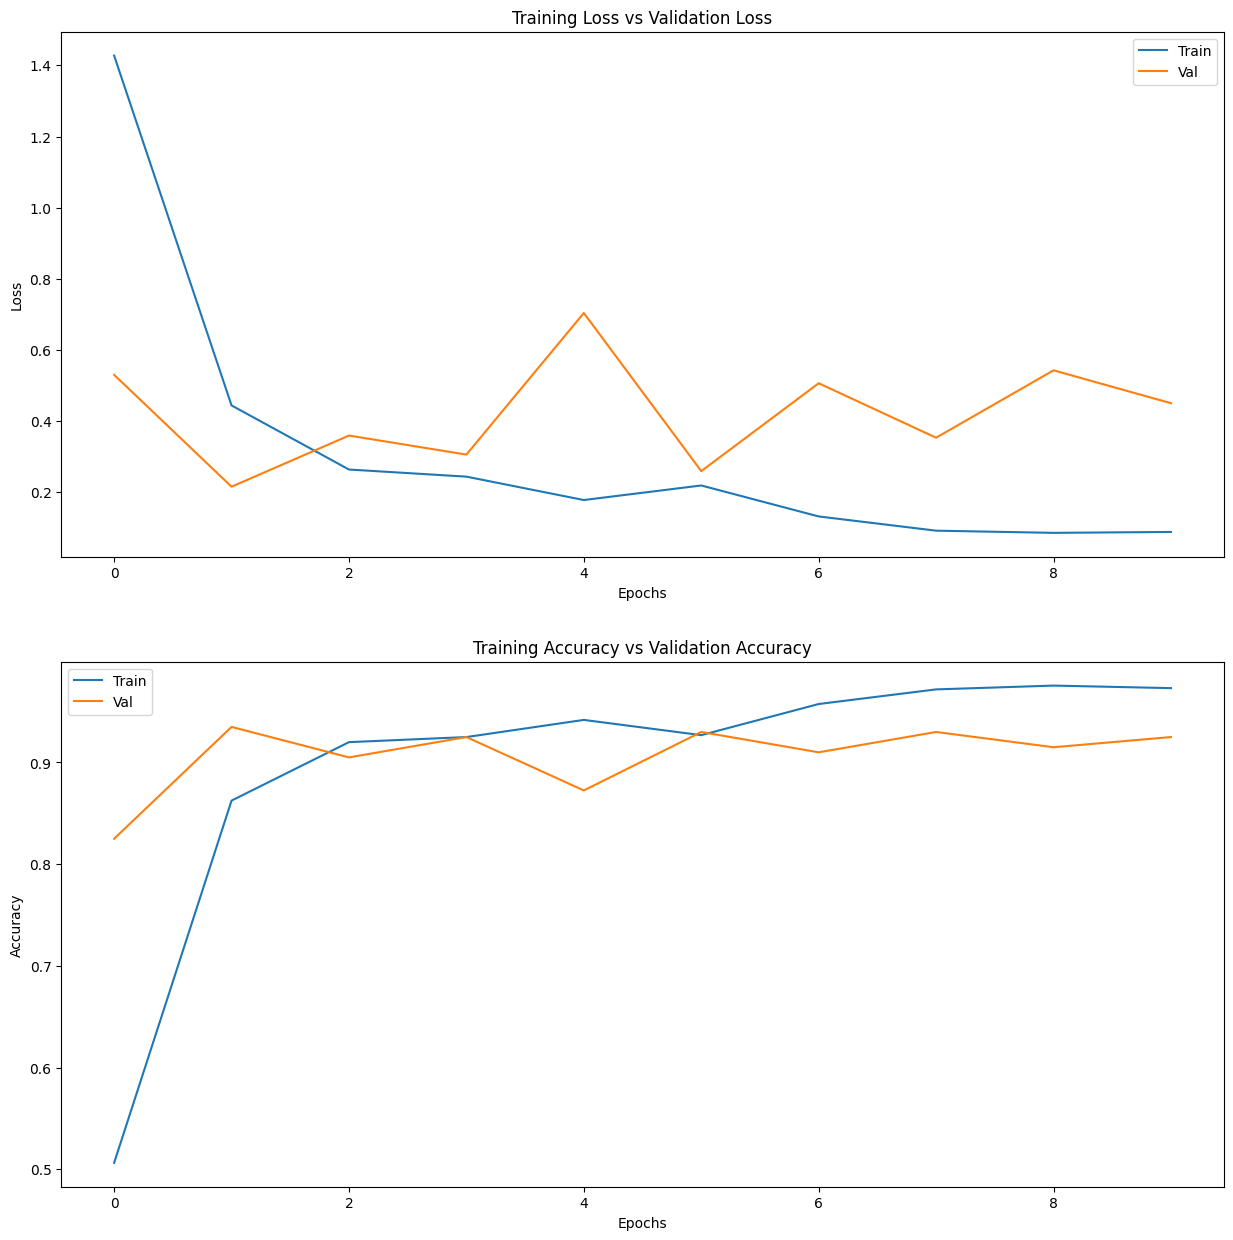

In [79]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train', 'Val'])
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

# VGGNet

## PyTorch

I again used a pretrained network, trained on the ImageNet dataset, to predict an image of my dog (a labrador retriever).

In [81]:
import torch
from torchvision import models, transforms
from PIL import Image


In [82]:
vgg19 = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1)

In [83]:
image_path = "ollie.jpg"

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image = Image.open(image_path)
image = transform(image)

In [84]:
vgg19.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

## TensorFlow

I again used a pretrained network, trained on the ImageNet dataset, to predict an image of my dog (a labrador retriever).

In [85]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions
import numpy as np

In [86]:
model = VGG19(weights='imagenet')

img_path = 'ollie.jpg'  # Picture of my yellow lab
img = image.load_img(img_path, target_size=(224, 224))

In [87]:
x = image.img_to_array(img)

In [88]:
x = np.expand_dims(x, axis=0)

In [89]:
x = preprocess_input(x)

In [90]:
predictions = model.predict(x)

1/1 [==============================] - 0s 326ms/step


In [91]:
decoded_predictions = decode_predictions(predictions)

In [92]:
for i in range(5):
    print(f'{decoded_predictions[0][i][1]}: {decoded_predictions[0][i][2]:.2f}')

Labrador_retriever: 0.81
American_Staffordshire_terrier: 0.05
beagle: 0.02
English_foxhound: 0.01
Walker_hound: 0.01


## Thoughts

I don't have much to say here. There are just a couple thoughts I had:

 - Obviously it is nice that PyTorch has both models pretrained. This would make transfer learning quicker and we should still be able to modify the layers of the networks.
 - Implementing the AlexNet by hand with TensorFlow was of course more difficult but does provide an extra layer of learning and is perhaps the more "academic" approach.
 - I like how you can get the decoded predictions for TensorFlow (at least for the VGGNet). I do not know if you can get these for PyTorch.